#Setup

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
from google.colab import drive
import pandas as pd
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


In [4]:
!pip install nltk
!pip install wordcloud
!pip install emoji
!pip install googletrans==4.0.0-rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.0 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=9fd0abd463900358b8c5f0676d4699165d593d725e9192e63cc5cd5d167399d4
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting un

#Dataset

Importación del dataset en pandas

In [8]:
df = pd.read_csv("toxicity_train_augmented_senior_20231102.csv", encoding='utf-8') #training
df_test = pd.read_csv("toxicity_test_augmented_senior_20231102.csv", encoding='utf-8') #test

In [9]:
df

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polem...,"Durante su intervenciÃ³n, el vicesecretario de...",0,news-articles,url,Espinosa de los Monteros has compared both pro...,Espinosa de los Monteros a comparé les deux ma...
1,1.271010900259078e+18,"Nueva manipulaciÃ³n a la mujer de la @rfef, dÃ...",1,twitter,twitterId,"New manipulation of the woman from @rfef, wher...","Nouvelle manipulation de la femme de la @rfef,..."
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Accion...,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing...,SOLIDARITÉ avec les 500 travailleurs d'Acciona...
3,1.2811132626507776e+18,âï¸ #BuenosDÃ­as #FelizJueves \n\n MaÃ±ana...,0,twitter,twitterId,âï¸ #GoodMorning #HappyThursday\n\nTomorrow...,âï¸ #Bonjour #JoyeuxJeudi\n\nDemain notre c...
4,1.465632198984405e+18,Porros o educaciÃ³n gratuita.\n\nAdoctrinamien...,1,twitter,twitterId,Joints or free education.\n\nProgressive indoc...,Joints ou éducation gratuite.\n\nEndoctrinemen...
...,...,...,...,...,...,...,...
10995,https://www.newtral.es/coronavirus-covid-casos...,[PANEL COVID |,0,news-articles,url,NaN,NaN
10996,https://www.newtral.es/centros-salud-comunidad...,"En concreto 10.043, el 76,7%.",0,news-articles,url,NaN,NaN
10997,http://www.lavanguardia.com/opinion/20170507/4...,"âNo, eso no.",0,news-articles,url,NaN,NaN
10998,http://www.vanitatis.elconfidencial.com/notici...,"""Se va para proteger a sus hijos.",0,news-articles,url,NaN,NaN


In [10]:
df_test

,id,text,label,origin,id-type,english,french
0,https://www.newtral.es/voto-internet-eleccione...,El ensayo con los espaÃ±oles en el extranjero ...,0,news-articles,url,The common denominator in the experts' opinion...,Le dénominateur commun dans l'opinion des expe...
1,1.4439912260432282e+18,Hoy a las 20:20 os espero en el programa @24ho...,0,twitter,twitterId,Today at 20:20 I'll be waiting for you on the ...,"Aujourd'hui à 20h20, je vous attends dans l'ém..."
2,https://maldita.es/feminismo/20230307/laboral-...,"AdemÃ¡s de la diferencia de salarios, hay una ...",0,news-articles,url,"""Worked hours are a homogeneous data that can ...","""Les heures travaillées sont une donnée homogè..."
3,https://www.alertadigital.com/2023/03/11/dieci...,"Â¿Por quÃ© si se grabÃ³ en GijÃ³n, aparece aÃ±...",0,news-articles,url,We didn't understand it at that moment.,Nous ne l'avons pas compris à ce moment-là.
4,1.3853418377209242e+18,Ha sido un placer entregar a @jonkortajarena s...,0,twitter,twitterId,It has been a pleasure to present @jonkortajar...,Cela a été un plaisir de remettre à @jonkortaj...
...,...,...,...,...,...,...,...
4995,1.451427698337849e+18,Hoy me he levantado un poco mÃ¡s temprano para...,0,twitter,twitterId,Today I woke up a little earlier for my abluti...,"Aujourd'hui, je me suis levé un peu plus tôt p..."
4996,https://www.marca.com/futbol/seleccion/2023/03...,"Y la conclusiÃ³n del informe es rotunda: ""Pert...",0,news-articles,url,"And the conclusion of the report is clear: ""He...",Et la conclusion du rapport est sans équivoque...
4997,1.4642168824882217e+18,#Cantabria solo avanza de la mano del @PSOE y ...,0,twitter,twitterId,Cantabria only moves forward hand in hand with...,La Cantabrie avance seulement de la main du @P...
4998,https://www.xataka.com/seleccion/este-smartpho...,"Por otro lado, este modelo incorpora un sistem...",0,news-articles,url,"On the other hand, this model incorporates an ...","D'autre part, ce modèle intègre un système d'e..."


#Análisis de Datos

No analizamos los datos del conjunto test para evitar fuga de datos (_data leakage_).

Tomar decisiones en base a conocimiento obtenido de un análisis del test puede llevar a una falsa percepción de mejor rendimiento que evite una buena generalización del modelo.

##Descripcion

Descripción del dataset.
Podemos ver que en la columna de inglés y francés hay algún valor no existente (NaN).

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       11000 non-null  object
 1   text     11000 non-null  object
 2   label    11000 non-null  int64 
 3   origin   11000 non-null  object
 4   id-type  11000 non-null  object
 5   english  9960 non-null   object
 6   french   9959 non-null   object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


In [12]:
df.describe(include='all')

,id,text,label,origin,id-type,english,french
count,11000,11000,11000.000000,11000,11000,9960,9959
unique,5545,9971,NaN,2,2,5529,5528
top,https://www.newtral.es/andreas-fernandez-muert...,Un titular.,NaN,news-articles,url,"On the other hand, not all herpetic encephalit...","D'autre part, toutes les encéphalites herpétiq..."
freq,80,12,NaN,5978,5978,76,76
mean,NaN,NaN,0.265273,NaN,NaN,NaN,NaN
std,NaN,NaN,0.441498,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


##Valores NaN

Analizamos los valores NaN para tratarlos posteriormente.

In [13]:
#Columnas con valores NaN
df.columns[df.isna().any()].tolist()

['english', 'french']

In [14]:
#Número de valores NaN por columna
print(df[['english']].isna().sum())
print(df[['french']].isna().sum())

english    1040
dtype: int64
french    1041
dtype: int64


In [15]:
#Filas con valores NaN
df[df[['english', 'french']].isna().any(axis=1)]

,id,text,label,origin,id-type,english,french
36,1.2678544403353682e+18,"Estas semanas, tambiÃ©n seguimos con nuestro t...",0,twitter,twitterId,NaN,"Ces dernières semaines, nous continuons égalem..."
88,1.2736806687578194e+18,El sector del transporte discrecional de viaje...,0,twitter,twitterId,NaN,"Le secteur du transport discret des passagers,..."
358,1.5115843949512049e+18,ð´ âKichiâ se cree que Cadiz es una RepÃ...,1,twitter,twitterId,NaN,"""Kichi"" croit que Cadix est une République bol..."
965,1.271495584466309e+18,El mundo al revÃ©s de Granados\n\nÃrase una v...,1,twitter,twitterId,"Once upon a time, there was a corrupt member o...",NaN
1621,1.272125636690219e+18,11-M al 8-M: la mentira de la izquierda entonc...,1,twitter,twitterId,11-M to 8-M: the lie of the left then and now:...,NaN
...,...,...,...,...,...,...,...
10995,https://www.newtral.es/coronavirus-covid-casos...,[PANEL COVID |,0,news-articles,url,NaN,NaN
10996,https://www.newtral.es/centros-salud-comunidad...,"En concreto 10.043, el 76,7%.",0,news-articles,url,NaN,NaN
10997,http://www.lavanguardia.com/opinion/20170507/4...,"âNo, eso no.",0,news-articles,url,NaN,NaN
10998,http://www.vanitatis.elconfidencial.com/notici...,"""Se va para proteger a sus hijos.",0,news-articles,url,NaN,NaN


##Distribuciones

Análisis de la proporción de las categorías (No analizamos id-type porque es derivado de origin).

Podemos ver que la clase predicha está desbalanceada (hay muchos más textos no-tóxicos)

In [16]:
#Comprobamos que origin equivale a id-type
result = df[(df['origin'] == 'news-articles') & (df['id-type'] != 'url') |
            (df['origin'] == 'twitter') & (df['id-type'] != 'twitterId')]

if not result.empty:
    print(result)
else:
    print("Las columnas son iguales")

Las columnas son iguales


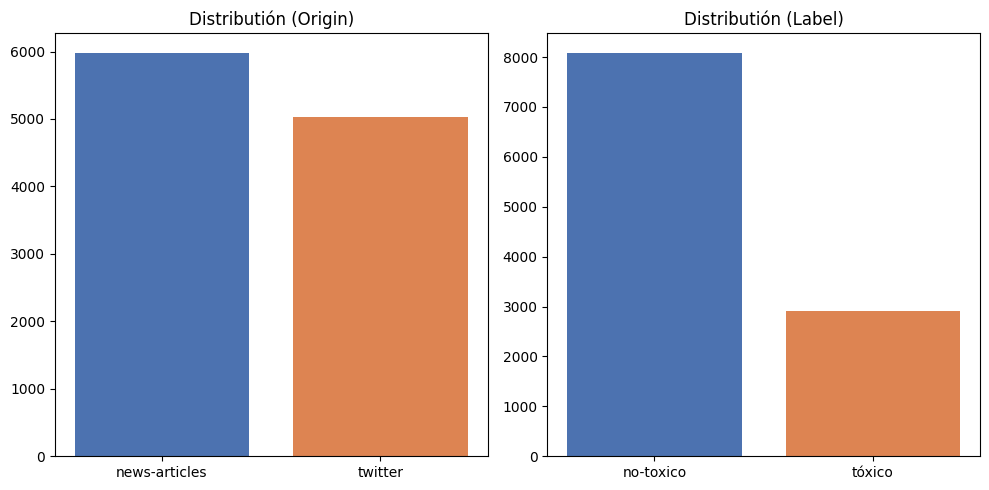

In [17]:
#Distribuciones
language_distribution = df.copy()['origin'].value_counts()
class_distribution = df.copy()['label'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

#origin
axes[0].bar(language_distribution.index, language_distribution.values, color=sns.color_palette("deep"))
axes[0].set_title('Distributión (Origin)')
axes[1].set_xticks(class_distribution.index)

#label
axes[1].bar(class_distribution.index.map({0: "no-toxico", 1: "tóxico"}), class_distribution.values, color=sns.color_palette("deep"))
axes[1].set_title('Distributión (Label)')
axes[1].set_xticks(class_distribution.index.map({0: "no-toxico", 1: "tóxico"}))

plt.tight_layout()
plt.show()

##Longitud

Comprobamos la longitud del texto por tweet en cada label.

Podemos ver una clara relación entre la longitud y la toxicidad del texto

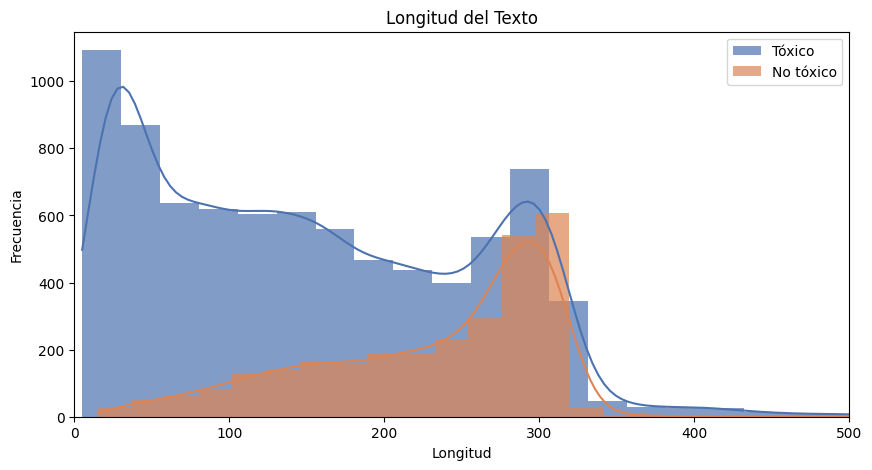

In [18]:
#Longitud de cada label
df_len_label1 = df[df['label'] == 0]['text'].apply(len)
df_len_label2 = df[df['label'] == 1]['text'].apply(len)

#Plot
plt.figure(figsize=(10, 5))
sns.histplot(df_len_label1, bins=30, kde=True, color=sns.color_palette("deep")[0], alpha=0.7, label='Tóxico', edgecolor='none')
sns.histplot(df_len_label2, bins=30, kde=True, color=sns.color_palette("deep")[1], alpha=0.7, label='No tóxico', edgecolor='none')
plt.title('Longitud del Texto')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.legend()
plt.xlim(0, 500)
plt.show()

##Wordcloud

Analizamos las principales palabras por cada label.

Podemos ver que hace falta preprocesar los textos para que tengan sentido.

Sin embargo, ya podemos notar que en el caso de los textos tóxicos hay muchos términos políticos ("Sánchez", "Podemos", "gobierno", "PSOE"...) con descalificativos ("progre", "mentira").

En los textos no-tóxicos también tenemos términos políticos, por lo que es posible que el modelo encuentre problemas a la hora de clasificar textos con estos términos.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


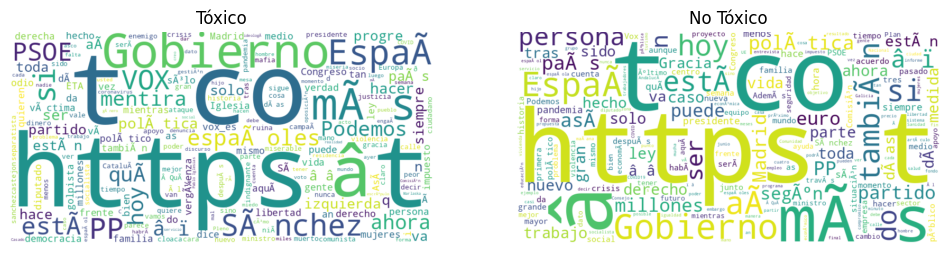

In [19]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

#Wordclouds
stop_words_spanish = set(stopwords.words('spanish'))
toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words_spanish).generate(' '.join(df.copy()[df['label'] == 1]["text"]))
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words_spanish).generate(' '.join(df.copy()[df['label'] == 0]["text"]))

#Plot
plt.figure(figsize=(12, 6))

#Plot toxico
plt.subplot(1, 2, 1)
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Tóxico')
plt.axis('off')

#Plot no-toxico
plt.subplot(1, 2, 2)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('No Tóxico')
plt.axis('off')

plt.show()

##Id

Comprobamos que todos los Id sean urls o tweeterIds

In [20]:
df[~((df['id'].astype(str).str.isdigit()) #Número (tweetid)
  | (df['id'].str.startswith('http:') #URL
  | df['id'].str.startswith('https:') #URL
  | df['id'].str.contains('.com')) #URL
  | (df['id'].str.match(r'\d+\.\d+e\+\d+')))]['id'] #Número (tweetid)

Series([], Name: id, dtype: object)

#Preprocessing

##NaN

Convertimos los valores NaN en cadenas de texto vacías para evitar problemas de procesamiento (luego trataremos de corregirlos)

In [21]:
def removeNaN(df):
  """
    Cambia los valores NaN por "".

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  df['english'].fillna("", inplace=True)
  df['french'].fillna("", inplace=True)
  return df

In [22]:
removeNaN(df)
df

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polem...,"Durante su intervenciÃ³n, el vicesecretario de...",0,news-articles,url,Espinosa de los Monteros has compared both pro...,Espinosa de los Monteros a comparé les deux ma...
1,1.271010900259078e+18,"Nueva manipulaciÃ³n a la mujer de la @rfef, dÃ...",1,twitter,twitterId,"New manipulation of the woman from @rfef, wher...","Nouvelle manipulation de la femme de la @rfef,..."
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Accion...,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing...,SOLIDARITÉ avec les 500 travailleurs d'Acciona...
3,1.2811132626507776e+18,âï¸ #BuenosDÃ­as #FelizJueves \n\n MaÃ±ana...,0,twitter,twitterId,âï¸ #GoodMorning #HappyThursday\n\nTomorrow...,âï¸ #Bonjour #JoyeuxJeudi\n\nDemain notre c...
4,1.465632198984405e+18,Porros o educaciÃ³n gratuita.\n\nAdoctrinamien...,1,twitter,twitterId,Joints or free education.\n\nProgressive indoc...,Joints ou éducation gratuite.\n\nEndoctrinemen...
...,...,...,...,...,...,...,...
10995,https://www.newtral.es/coronavirus-covid-casos...,[PANEL COVID |,0,news-articles,url,,
10996,https://www.newtral.es/centros-salud-comunidad...,"En concreto 10.043, el 76,7%.",0,news-articles,url,,
10997,http://www.lavanguardia.com/opinion/20170507/4...,"âNo, eso no.",0,news-articles,url,,
10998,http://www.vanitatis.elconfidencial.com/notici...,"""Se va para proteger a sus hijos.",0,news-articles,url,,


##UTF-8 Encoding

El texto tiene caracteres extraños que parecen indicar que el el encoding utilizado es latin-1 y debería ser utf-8.

Cambiamos el encoding a utf-8 para mejorar la legibilidad del texto.

In [23]:
def utf8(df):
  """
    Codifica los textos en utf8.

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  df['text'] = df['text'].apply(lambda x : x.encode('latin-1', errors='replace').decode('utf-8', errors='replace'))
  df['english'] = df['english'].apply(lambda x : x.encode('latin-1', errors='replace').decode('utf-8', errors='replace'))
  df['french'] = df['french'].apply(lambda x : x.encode('latin-1', errors='replace').decode('utf-8', errors='replace'))
  return df

In [24]:
utf8(df)
df

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polem...,"Durante su intervención, el vicesecretario de ...",0,news-articles,url,Espinosa de los Monteros has compared both pro...,Espinosa de los Monteros a compar� les deux ma...
1,1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dón...",1,twitter,twitterId,"New manipulation of the woman from @rfef, wher...","Nouvelle manipulation de la femme de la @rfef,..."
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Accion...,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing...,SOLIDARIT� avec les 500 travailleurs d'Acciona...
3,1.2811132626507776e+18,☀️ #BuenosDías #FelizJueves \n\n Mañana nuest...,0,twitter,twitterId,☀️ #GoodMorning #HappyThursday\n\nTomorrow our...,☀️ #Bonjour #JoyeuxJeudi\n\nDemain notre candi...
4,1.465632198984405e+18,Porros o educación gratuita.\n\nAdoctrinamient...,1,twitter,twitterId,Joints or free education.\n\nProgressive indoc...,Joints ou �ducation gratuite.\n\nEndoctrinemen...
...,...,...,...,...,...,...,...
10995,https://www.newtral.es/coronavirus-covid-casos...,[PANEL COVID |,0,news-articles,url,,
10996,https://www.newtral.es/centros-salud-comunidad...,"En concreto 10.043, el 76,7%.",0,news-articles,url,,
10997,http://www.lavanguardia.com/opinion/20170507/4...,"–No, eso no.",0,news-articles,url,,
10998,http://www.vanitatis.elconfidencial.com/notici...,"""Se va para proteger a sus hijos.",0,news-articles,url,,


##Links

Eliminamos las urls https://t.co (un wrapper de twitter para urls).

Eliminamos solo estas urls porque otras pueden guardar información útil para el modelo.

Tras esto, mostramos de nuevo las wordclouds para visualizar mejor los resultados

In [25]:
import re

def removeLinks(df):
  """
    Elimina urls de tweeter.

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  df['text'] = df['text'].apply(lambda x : re.sub(r'https://t.co\S+', '', x))
  df['text'] = df['text'].apply(lambda x : re.sub(r'http://t.co\S+', '', x))
  return df

In [26]:
removeLinks(df)
df

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polem...,"Durante su intervención, el vicesecretario de ...",0,news-articles,url,Espinosa de los Monteros has compared both pro...,Espinosa de los Monteros a compar� les deux ma...
1,1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dón...",1,twitter,twitterId,"New manipulation of the woman from @rfef, wher...","Nouvelle manipulation de la femme de la @rfef,..."
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Accion...,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing...,SOLIDARIT� avec les 500 travailleurs d'Acciona...
3,1.2811132626507776e+18,☀️ #BuenosDías #FelizJueves \n\n Mañana nuest...,0,twitter,twitterId,☀️ #GoodMorning #HappyThursday\n\nTomorrow our...,☀️ #Bonjour #JoyeuxJeudi\n\nDemain notre candi...
4,1.465632198984405e+18,Porros o educación gratuita.\n\nAdoctrinamient...,1,twitter,twitterId,Joints or free education.\n\nProgressive indoc...,Joints ou �ducation gratuite.\n\nEndoctrinemen...
...,...,...,...,...,...,...,...
10995,https://www.newtral.es/coronavirus-covid-casos...,[PANEL COVID |,0,news-articles,url,,
10996,https://www.newtral.es/centros-salud-comunidad...,"En concreto 10.043, el 76,7%.",0,news-articles,url,,
10997,http://www.lavanguardia.com/opinion/20170507/4...,"–No, eso no.",0,news-articles,url,,
10998,http://www.vanitatis.elconfidencial.com/notici...,"""Se va para proteger a sus hijos.",0,news-articles,url,,


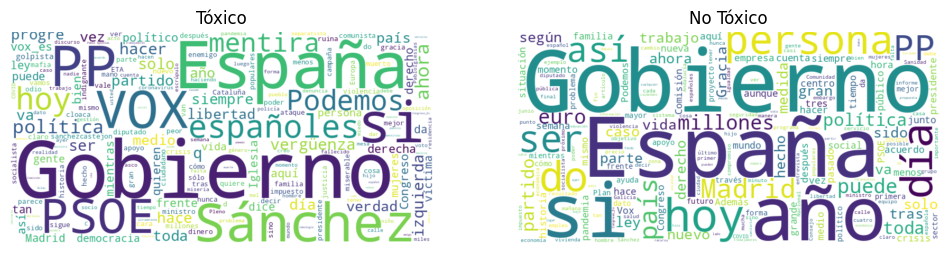

In [27]:
toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words_spanish).generate(' '.join(df.copy()[df['label'] == 1]["text"]))
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words_spanish).generate(' '.join(df.copy()[df['label'] == 0]["text"]))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Tóxico')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('No Tóxico')
plt.axis('off')

plt.show()

##Emojis

Cambiamos los emojis por su descripción.

Los modelos de lenguaje suelen haber sido entrenados con emojis por lo que no debería ser necesario, pero este paso puede mejorar la legibilidad. Además en en el contexto analizado, los emojis pueden representar cosas que alteren el sentido de la frase (🤢) o añadir connotaciones políticas (🐍)

In [28]:
import emoji

def removeEmoji(df):
  """
    Elimina los emojis.

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  df['text'] = df['text'].apply(lambda x: emoji.demojize(x, language='es'))
  df['english'] = df['english'].apply(lambda x: emoji.demojize(x))
  df['french'] = df['french'].apply(lambda x: emoji.demojize(x, language='fr'))
  return df

In [29]:
removeEmoji(df)
df

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polem...,"Durante su intervención, el vicesecretario de ...",0,news-articles,url,Espinosa de los Monteros has compared both pro...,Espinosa de los Monteros a compar� les deux ma...
1,1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dón...",1,twitter,twitterId,"New manipulation of the woman from @rfef, wher...","Nouvelle manipulation de la femme de la @rfef,..."
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Accion...,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing...,SOLIDARIT� avec les 500 travailleurs d'Acciona...
3,1.2811132626507776e+18,:sol: #BuenosDías #FelizJueves \n\n Mañana nu...,0,twitter,twitterId,:sun: #GoodMorning #HappyThursday\n\nTomorrow ...,:soleil: #Bonjour #JoyeuxJeudi\n\nDemain notre...
4,1.465632198984405e+18,Porros o educación gratuita.\n\nAdoctrinamient...,1,twitter,twitterId,Joints or free education.\n\nProgressive indoc...,Joints ou �ducation gratuite.\n\nEndoctrinemen...
...,...,...,...,...,...,...,...
10995,https://www.newtral.es/coronavirus-covid-casos...,[PANEL COVID |,0,news-articles,url,,
10996,https://www.newtral.es/centros-salud-comunidad...,"En concreto 10.043, el 76,7%.",0,news-articles,url,,
10997,http://www.lavanguardia.com/opinion/20170507/4...,"–No, eso no.",0,news-articles,url,,
10998,http://www.vanitatis.elconfidencial.com/notici...,"""Se va para proteger a sus hijos.",0,news-articles,url,,


##Translation

En este paso cambiamos los valores NaN (que hemos convertidos en cadenas de texto vacías) en la correspondiente traducción.

Para ello utilizaremos la librería mtranslate (una api de google translate). Utilizamos esta librería para el preprocesado del set de entrenamiento en este caso. En caso de utilizarlo para un modelo en producción, sería necesario asegurarnos de la escalabilidad del modelo (demasiadas request a la api de google translate puede conllevar un baneo) y el mantenimiento del modelo (con google translate no debería haber problema pero hay apis de traducción que podrían no estar mantenidos de forma regular).


In [30]:
!pip install mtranslate

  Preparing metadata (setup.py) ... done
  Created wheel for mtranslate: filename=mtranslate-1.8-py3-none-any.whl size=3672 sha256=0d25e1cac6baabacd408e67a5e448da03426e56a011093abbc57f27656d9e830
  Stored in directory: /root/.cache/pip/wheels/c2/04/15/d7654c2c4a9a52e09922967593f3278fed66059be65ca671ea
Successfully built mtranslate


In [31]:
from googletrans import Translator
from mtranslate import translate

def translateDF(df):
  """
    Traduce los campos vacíos.

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  translator = Translator()
  df['english'] = df.apply(lambda row: translate(row['text'], 'en') if row['english']=="" else row['english'], axis=1)
  df['french'] = df.apply(lambda row: translate(row['text'], 'fr') if row['french']=="" else row['french'], axis=1)
  return df

In [32]:
df = translateDF(df)
df

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polem...,"Durante su intervención, el vicesecretario de ...",0,news-articles,url,Espinosa de los Monteros has compared both pro...,Espinosa de los Monteros a compar� les deux ma...
1,1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dón...",1,twitter,twitterId,"New manipulation of the woman from @rfef, wher...","Nouvelle manipulation de la femme de la @rfef,..."
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Accion...,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing...,SOLIDARIT� avec les 500 travailleurs d'Acciona...
3,1.2811132626507776e+18,:sol: #BuenosDías #FelizJueves \n\n Mañana nu...,0,twitter,twitterId,:sun: #GoodMorning #HappyThursday\n\nTomorrow ...,:soleil: #Bonjour #JoyeuxJeudi\n\nDemain notre...
4,1.465632198984405e+18,Porros o educación gratuita.\n\nAdoctrinamient...,1,twitter,twitterId,Joints or free education.\n\nProgressive indoc...,Joints ou �ducation gratuite.\n\nEndoctrinemen...
...,...,...,...,...,...,...,...
10995,https://www.newtral.es/coronavirus-covid-casos...,[PANEL COVID |,0,news-articles,url,[PANEL COVID |,[PANNEAU COVID |
10996,https://www.newtral.es/centros-salud-comunidad...,"En concreto 10.043, el 76,7%.",0,news-articles,url,"Specifically 10,043, 76.7%.","Plus précisément 10 043, soit 76,7 %."
10997,http://www.lavanguardia.com/opinion/20170507/4...,"–No, eso no.",0,news-articles,url,"-No, not that.","-Non, pas ça."
10998,http://www.vanitatis.elconfidencial.com/notici...,"""Se va para proteger a sus hijos.",0,news-articles,url,"""He leaves to protect his children.","""Il part protéger ses enfants."


In [33]:
empty_english = df[df['english'] == '']
empty_french = df[df['french'] == '']

print(empty_english)

print(empty_french)

Empty DataFrame
Columns: [id, text, label, origin, id-type, english, french]
Index: []
Empty DataFrame
Columns: [id, text, label, origin, id-type, english, french]
Index: []


##ID

Convertimos las IDs en la palabra del servicio principal (twitter o la correspondiente página de noticias).

Utilizaremos un sencillo sistema de reglas debido a que con esto funciona en nuestro _dataset_, pero en caso de tener más datos sería necesario ir mejorando nuestro sistema de reglas para tener en cuenta casos diferentes.

In [69]:
def preprocessID(df):
  """
    Cambia el id por tweeter (si es un numero) o la página correspondiente (si es una url).

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  def change_id(row):
    res = ""
    if ("elpais" in row): #Caso elpais (problemas con el dominio "is.")
      res = row.split('.')[0].replace('https://',"").replace('http://',"")
    elif ("www.alimente." in row): #Caso www.alimente (subdominio especial)
      res = row.split('.')[2].replace('https://',"").replace('http://',"")
    elif ("www." in row) or ("ww." in row) or ("beta." in row) or ("tis." in row) or ("is." in row): #Caso general subdominios
      res = row.split('.')[1].replace('https://',"").replace('http://',"")
    elif row.startswith('http:') or row.startswith('https:') or ('.com' in row): #Caso urls sin subdominio
      res = row.split('.')[0].replace('https://',"").replace('http://',"")
    elif re.match(r'\d+\.\d+e\+\d+', row): #Caso tweeterID
      res = 'tweeter'
    return res

  df['id'] = df["id"].apply(change_id)

  return df

In [85]:
df = preprocessID(df)
df

,id,text,label,origin,id-type,english,french
0,elplural,"Durante su intervención, el vicesecretario de ...",0,news-articles,url,Espinosa de los Monteros has compared both pro...,Espinosa de los Monteros a compar� les deux ma...
1,tweeter,"Nueva manipulación a la mujer de la @rfef, dón...",1,twitter,twitterId,"New manipulation of the woman from @rfef, wher...","Nouvelle manipulation de la femme de la @rfef,..."
2,tweeter,SOLIDARIDAD con los 500 trabajadores de Accion...,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing...,SOLIDARIT� avec les 500 travailleurs d'Acciona...
3,tweeter,:sol: #BuenosDías #FelizJueves \n\n Mañana nu...,0,twitter,twitterId,:sun: #GoodMorning #HappyThursday\n\nTomorrow ...,:soleil: #Bonjour #JoyeuxJeudi\n\nDemain notre...
4,tweeter,Porros o educación gratuita.\n\nAdoctrinamient...,1,twitter,twitterId,Joints or free education.\n\nProgressive indoc...,Joints ou �ducation gratuite.\n\nEndoctrinemen...
...,...,...,...,...,...,...,...
10995,newtral,[PANEL COVID |,0,news-articles,url,,
10996,newtral,"En concreto 10.043, el 76,7%.",0,news-articles,url,,
10997,lavanguardia,"–No, eso no.",0,news-articles,url,,
10998,vanitatis,"""Se va para proteger a sus hijos.",0,news-articles,url,,


In [86]:
df["id"].unique()

array(['elplural', 'tweeter', 'blogs', 'newtral', 'eldiario',
       'elconfidencial', 'vanitatis', 'lavozdegalicia', 'elsaltodiario',
       'alertadigital', 'elespanol', 'periodistadigital',
       'libertaddigital', 'infolibre', 'ara', 'noticiasdealava',
       'larazon', 'elpais', 'europapress', 'as', 'granadahoy', 'hola',
       'elmundo', 'okdiario', 'kioskoymas', 'nfidencial', 'onfidencial',
       'lavanguardia', 'infosalus', 'dencial', 'confidencial'],
      dtype=object)

Text(0.5, 1.0, 'Origin Distribution')

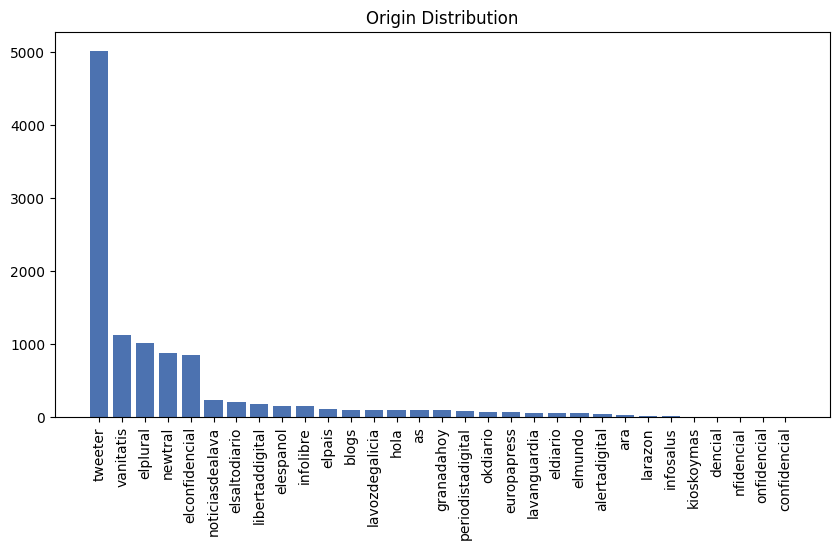

In [87]:
id_distribution = df.copy()['id'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(id_distribution.index, id_distribution.values, color=sns.color_palette("deep")[0])
plt.xticks(rotation='vertical')
plt.title('Origin Distribution')

##Correlación de Features

Comprobamos con un modelo de random forest que existe una muy pequeña correlación entre el id y el label.

Después vamos a asegurar de forma experimental entrenando dos modelos de lenguaje (uno con ID y otro sin ella) si realmente existe esta correlación en el modelo final.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Definimos las clases con posible correlacion
df_corr = df.copy()[['id', 'label']]

#Hacemos un one-hot encoding
df_corr = pd.get_dummies(df_corr, columns=['id'], drop_first=True)

#Definimos feature y label
X = df_corr.drop('label', axis=1)
y = df_corr['label']

#Entrenamiento randomForest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)

#Resultados
feature_importances = rf_classifier.feature_importances_
feature_importance_dict = dict(zip(X.columns, feature_importances))

print("Feature Importances:\n")
print("Media", feature_importances.mean(),"\n")
for feature, importance in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")


Feature Importances:

Media 0.03333333333333333 

id_tweeter: 0.707759463419549
id_vanitatis: 0.07587000989552205
id_newtral: 0.054661825482436456
id_elconfidencial: 0.04792113724249581
id_elplural: 0.04185707804033844
id_elsaltodiario: 0.010102862182886106
id_noticiasdealava: 0.00940948508948099
id_elespanol: 0.00776386551697892
id_infolibre: 0.006695266292595926
id_libertaddigital: 0.005104876303144608
id_okdiario: 0.004342806035022366
id_as: 0.0042399031668127985
id_blogs: 0.0038649397988761883
id_elpais: 0.003495115929696744
id_hola: 0.0027697601866130918
id_lavozdegalicia: 0.002717413357432256
id_europapress: 0.002318052762481912
id_granadahoy: 0.00197580939410592
id_eldiario: 0.0017488095744748109
id_lavanguardia: 0.0017310710912435913
id_periodistadigital: 0.0015347115975700772
id_elmundo: 0.0009542115154598974
id_larazon: 0.0005770124634880498
id_ara: 0.0003047214953212277
id_infosalus: 0.00013522598323194437
id_kioskoymas: 0.00010003485866454058
id_dencial: 2.0828742297397246e

##ID $\to$ Text

Añadimos la ID al texto para comprobar si realmente este pudiese contener información útil para el modelo durante el entrenamiento (por ejemplo, hay medios que podrían contener más textos tóxicos que otros).

In [70]:
def applyID(df):
  """
    Aplica el ID a la columna de texto.

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  df['text'] = "[" + df['id'] + "] " + df['text']
  df['english'] = "[" + df['id'] + "] " + df['english']
  df['french'] = "[" + df['id'] + "] " + df['french']
  return df

In [89]:
df = applyID(df)
df

,id,text,label,origin,id-type,english,french
0,elplural,"[elplural] Durante su intervención, el vicesec...",0,news-articles,url,[elplural] Espinosa de los Monteros has compar...,[elplural] Espinosa de los Monteros a compar� ...
1,tweeter,[tweeter] Nueva manipulación a la mujer de la ...,1,twitter,twitterId,[tweeter] New manipulation of the woman from @...,[tweeter] Nouvelle manipulation de la femme de...
2,tweeter,[tweeter] SOLIDARIDAD con los 500 trabajadores...,1,twitter,twitterId,[tweeter] SOLIDARITY with the 500 Acciona work...,[tweeter] SOLIDARIT� avec les 500 travailleurs...
3,tweeter,[tweeter] :sol: #BuenosDías #FelizJueves \n\n ...,0,twitter,twitterId,[tweeter] :sun: #GoodMorning #HappyThursday\n\...,[tweeter] :soleil: #Bonjour #JoyeuxJeudi\n\nDe...
4,tweeter,[tweeter] Porros o educación gratuita.\n\nAdoc...,1,twitter,twitterId,[tweeter] Joints or free education.\n\nProgres...,[tweeter] Joints ou �ducation gratuite.\n\nEnd...
...,...,...,...,...,...,...,...
10995,newtral,[newtral] [PANEL COVID |,0,news-articles,url,[newtral],[newtral]
10996,newtral,"[newtral] En concreto 10.043, el 76,7%.",0,news-articles,url,[newtral],[newtral]
10997,lavanguardia,"[lavanguardia] –No, eso no.",0,news-articles,url,[lavanguardia],[lavanguardia]
10998,vanitatis,"[vanitatis] ""Se va para proteger a sus hijos.",0,news-articles,url,[vanitatis],[vanitatis]


#Model Training Pipeline

Definimos la pipeline para entrenar modelos.

Utilizaremos un subset del entrenamiento como evaluación para evitar la fuga de datos, de forma que el test se utilize solo al final para evaluar de forma imparcial.

##Setup

In [34]:
!pip install transformers
!pip install transformers[torch]
!pip install accelerate>=0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.7 MB/s eta 0:00:00


In [35]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from transformers import Trainer,TrainingArguments

In [36]:
#Utilizamos un modelo multilingue
model_name  = 'bert-base-multilingual-uncased'

In [37]:
#Definimos el tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)lingual-uncased/resolve/main/config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

(…)tilingual-uncased/resolve/main/vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

(…)gual-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [38]:
#Creamos un dataframe con los campos necesarios para el entrenamiento
df_pre = pd.concat([
    df[['text', 'label']],
    df[['english', 'label']].rename(columns={'english': 'text'}),
    df[['french', 'label']].rename(columns={'french': 'text'})
], ignore_index=True)

#Eliminamos campos vacios (en caso de haberlos)
df_pre = df_pre[df_pre['text'] != '']

df_pre

,text,label
0,"Durante su intervención, el vicesecretario de ...",0
1,"Nueva manipulación a la mujer de la @rfef, dón...",1
2,SOLIDARIDAD con los 500 trabajadores de Accion...,1
3,:sol: #BuenosDías #FelizJueves \n\n Mañana nu...,0
4,Porros o educación gratuita.\n\nAdoctrinamient...,1
...,...,...
32995,[PANNEAU COVID |,0
32996,"Plus précisément 10 043, soit 76,7 %.",0
32997,"-Non, pas ça.",0
32998,"""Il part protéger ses enfants.",0


In [39]:
from sklearn.model_selection import train_test_split

#Definimos la feature y el label
X = df_pre["text"]
y = df_pre["label"]

#Definimos un set de evaluación
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

print("X_train", len(X_train), "| X_eval:", len(X_eval), "| y_train:", len(y_train), "| y_eval:", len(y_eval))
print("\n\n")
print(X_train)
print("\n\n")
print(X_eval)
print("\n\n")
print(y_train, )
print("\n\n")
print(y_eval)

X_train 29700 | X_eval: 3300 | y_train: 29700 | y_eval: 3300



8383     BOE | Así será la nueva tarifa de último recur...
20798    Asked about her vote in the regional elections...
27918    Ce sont 475 836 de plus par rapport au dernier...
5808     Iluminador en tono Pure Gold de la gama Synchr...
10906                       Un look de inspiración Hepburn
                               ...                        
20757                         Narration of a soccer match.
32103                      "Cela allume une lumière jaune.
30403    Selon les explications fournies, les rapports ...
21243                 Is there no more informational life?
2732       El próximo lunes 15 de junio, a partir de la...
Name: text, Length: 29700, dtype: object



11609    In the end, he presented some of the dishes he...
7564     La #SentenciaERE es demoledora para el PSOE: 1...
18998    For those of us who carry Toledo in our hearts...
13504    The @parlamentoNA and the Platform of Social E...
15058  

In [40]:
#Encodeamos los textos
train_encodings = tokenizer(X_train.values.tolist(), truncation=True, padding=True, return_tensors = 'pt')
val_encodings = tokenizer(X_eval.values.tolist(), truncation=True, padding=True, return_tensors = 'pt')

In [45]:
#Dataset train
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#Dataset test
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

In [46]:
#Creamos los datasets
train_dataset = SentimentDataset(train_encodings, y_train.values.tolist())
val_dataset = SentimentDataset(val_encodings, y_eval.values.tolist())

In [47]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

#Funcion para mostrar las métricas del modelo durante el entrenamiento
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy":accuracy,"recall":recall,"precision":precision,"f1_score":f1}

In [48]:
#Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./res',
    evaluation_strategy="steps",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs4',
    load_best_model_at_end=True,
)

In [49]:
#Vaciamos el cache de cuda (ayuda con la memoria)
torch.cuda.empty_cache()

##Entrenamiento del Modelo

In [50]:
#Definimos el modelo
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

#Entrenamos el modelo
trainer.train()

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-45-1cd71f6f445e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1 Score
500,0.378600,0.263632,0.901212,0.839041,0.798913,0.901970
1000,0.297100,0.276925,0.903636,0.755708,0.864230,0.901478
1500,0.262600,0.245564,0.920000,0.810502,0.878713,0.918938
2000,0.229100,0.253833,0.922424,0.818493,0.880835,0.921491
2500,0.179700,0.265008,0.911515,0.924658,0.781853,0.913707
3000,0.193600,0.255682,0.928788,0.843607,0.882915,0.928261
3500,0.168700,0.223584,0.940303,0.874429,0.898007,0.940047
4000,0.134800,0.221212,0.942727,0.915525,0.874591,0.943138
4500,0.105000,0.253095,0.940303,0.906393,0.873487,0.940650
5000,0.096500,0.240935,0.942424,0.878995,0.901639,0.942188


<ipython-input-45-1cd71f6f445e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-45-1cd71f6f445e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-45-1cd71f6f445e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-45-1cd71f6f445e>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=5571, training_loss=0.19405907759480706, metrics={'train_runtime': 3511.1874, 'train_samples_per_second': 25.376, 'train_steps_per_second': 1.587, 'total_flos': 2.3443195032576e+16, 'train_loss': 0.19405907759480706, 'epoch': 3.0})

##Comparativa de modelos

Utilizaremos de preprocesado+ID ya que mejora el rendimiento del que utiliza solo preprocesado durante el entrenamiento y que el tiempo que requiere no es mucho mayor.

Utilizamos como métrica de comparativa el F1-score ya que esta funciona mejor en _datasets_ desbalanceados al lograr un balance entre el precision y el recall.

bert-base-multilingual-cased preprocesado

| Step | Training Loss | Validation Loss | Accuracy | Recall | Precision | F1 Score |
|------|---------------|------------------|----------|--------|-----------|----------|
| 500  | 0.378600      | 0.263632         | 0.901212 | 0.839041 | 0.798913 | 0.901970 |
| 1000 | 0.297100      | 0.276925         | 0.903636 | 0.755708 | 0.864230 | 0.901478 |
| 1500 | 0.262600      | 0.245564         | 0.920000 | 0.810502 | 0.878713 | 0.918938 |
| 2000 | 0.229100      | 0.253833         | 0.922424 | 0.818493 | 0.880835 | 0.921491 |
| 2500 | 0.179700      | 0.265008         | 0.911515 | 0.924658 | 0.781853 | 0.913707 |
| 3000 | 0.193600      | 0.255682         | 0.928788 | 0.843607 | 0.882915 | 0.928261 |
| 3500 | 0.168700      | 0.223584         | 0.940303 | 0.874429 | 0.898007 | 0.940047 |
| 4000 | 0.134800      | 0.221212         | 0.942727 | 0.915525 | 0.874591 | 0.943138 |
| 4500 | 0.105000      | 0.253095         | 0.940303 | 0.906393 | 0.873487 | 0.940650 |
| 5000 | 0.096500      | 0.240935         | 0.942424 | 0.878995 | 0.901639 | 0.942188 |
| 5500 | 0.103400      | 0.225163         | 0.943333 | 0.860731 | 0.920635 | 0.942710 |


</br></br>

bert-base-multilingual-cased preprocesado+id

| Step | Training Loss | Validation Loss | Accuracy | Recall | Precision | F1 Score |
|------|---------------|------------------|----------|--------|-----------|----------|
| 500  | 0.374300      | 0.256359         | 0.895152 | 0.886986 | 0.758789 | 0.897584 |
| 1000 | 0.290800      | 0.270116         | 0.913939 | 0.859589 | 0.823851 | 0.914513 |
| 1500 | 0.256300      | 0.227175         | 0.918182 | 0.819635 | 0.865060 | 0.917463 |
| 2000 | 0.229100      | 0.253776         | 0.928182 | 0.844749 | 0.879905 | 0.927707 |
| 2500 | 0.171600      | 0.250610         | 0.924242 | 0.899543 | 0.829474 | 0.925190 |
| 3000 | 0.176300      | 0.292962         | 0.927273 | 0.803653 | 0.911917 | 0.925742 |
| 3500 | 0.158200      | 0.241910         | 0.941515 | 0.878995 | 0.898483 | 0.941309 |
| 4000 | 0.127800      | 0.255043         | 0.937273 | 0.899543 | 0.868798 | 0.937616 |
| 4500 | 0.087900      | 0.256165         | 0.945152 | 0.889269 | 0.902665 | 0.945020 |
| 5000 | 0.091500      | 0.244081         | 0.945152 | 0.877854 | 0.912218 | 0.944810 |
| 5500 | 0.086300      | 0.248155         | 0.943333 | 0.859589 | 0.921665 | 0.942687 |





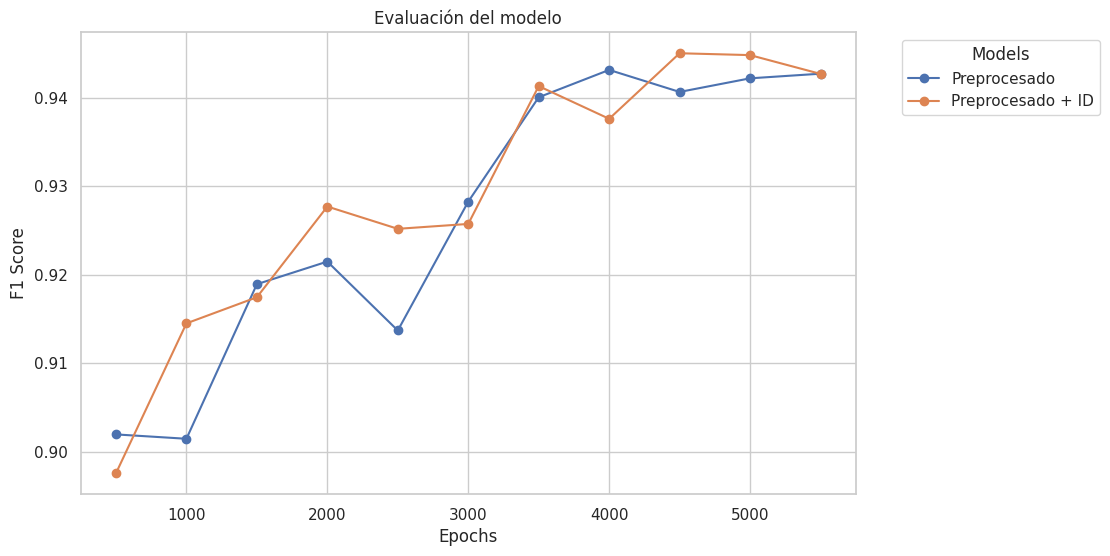

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data_bert_preprocesado = {
    'Step': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500],
    'Training Loss': [0.3786, 0.2971, 0.2626, 0.2291, 0.1797, 0.1936, 0.1687, 0.1348, 0.105, 0.0965, 0.1034],
    'Validation Loss': [0.263632, 0.276925, 0.245564, 0.253833, 0.265008, 0.255682, 0.223584, 0.221212, 0.253095, 0.240935, 0.225163],
    'Accuracy': [0.901212, 0.903636, 0.92, 0.922424, 0.911515, 0.928788, 0.940303, 0.942727, 0.940303, 0.942424, 0.943333],
    'Recall': [0.839041, 0.755708, 0.810502, 0.818493, 0.924658, 0.843607, 0.874429, 0.915525, 0.906393, 0.878995, 0.860731],
    'Precision': [0.798913, 0.86423, 0.878713, 0.880835, 0.781853, 0.882915, 0.898007, 0.874591, 0.873487, 0.901639, 0.920635],
    'F1 Score': [0.90197, 0.901478, 0.918938, 0.921491, 0.913707, 0.928261, 0.940047, 0.943138, 0.94065, 0.942188, 0.94271]
}

data_bert_preprocesado_id = {
    'Step': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500],
    'Training Loss': [0.3743, 0.2908, 0.2563, 0.2291, 0.1716, 0.1763, 0.1582, 0.1278, 0.0879, 0.0915, 0.0863],
    'Validation Loss': [0.256359, 0.270116, 0.227175, 0.253776, 0.25061, 0.292962, 0.24191, 0.255043, 0.256165, 0.244081, 0.248155],
    'Accuracy': [0.895152, 0.913939, 0.918182, 0.928182, 0.924242, 0.927273, 0.941515, 0.937273, 0.945152, 0.945152, 0.943333],
    'Recall': [0.886986, 0.859589, 0.819635, 0.844749, 0.899543, 0.803653, 0.878995, 0.899543, 0.889269, 0.877854, 0.859589],
    'Precision': [0.758789, 0.823851, 0.86506, 0.879905, 0.829474, 0.911917, 0.898483, 0.868798, 0.902665, 0.912218, 0.921665],
    'F1 Score': [0.897584, 0.914513, 0.917463, 0.927707, 0.92519, 0.925742, 0.941309, 0.937616, 0.94502, 0.94481, 0.942687]
}

# Create DataFrames
df_bert_preprocesado = pd.DataFrame(data_bert_preprocesado)
df_bert_preprocesado_id = pd.DataFrame(data_bert_preprocesado_id)


sns.set(style="whitegrid", palette=sns.color_palette("deep"))
color_cycle = iter(sns.color_palette("deep"))
plt.figure(figsize=(10, 6))

models = ["Preprocesado", "Preprocesado + ID"]
for count, model in enumerate([data_bert_preprocesado, data_bert_preprocesado_id]):
    color = next(color_cycle)
    plt.plot(model["Step"], model["F1 Score"], marker='o', label=models[count], color=color)

#plt.ylim(0.9, 0.93)

plt.title('Evaluación del modelo')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


#Testing

##Preprocesado

Preprocesamos el set de test como hicimos con el de entrenamiento

In [71]:
def preprocessDF(df):
  """
    Aplicamos todos los pasos para el preprocesado del test dataset.

    Parameters:
    - df: El dataframe a tratar.

    Returns:
    - df: El dataframe resultante.
    """
  df = removeNaN(df)
  df = utf8(df)
  df = removeLinks(df)
  df = removeEmoji(df)
  df = preprocessID(df)
  df = applyID(df)
  return df

In [72]:
df_test = preprocessDF(df_test)
df_test

,id,text,label,origin,id-type,english,french
0,newtral,[newtral] El ensayo con los espa?oles en el ex...,0,news-articles,url,[newtral] The common denominator in the expert...,[newtral] Le d?nominateur commun dans l'opinio...
1,tweeter,[tweeter] Hoy a las 20:20 os espero en el prog...,0,twitter,twitterId,[tweeter] Today at 20:20 I'll be waiting for y...,"[tweeter] Aujourd'hui ? 20h20, je vous attends..."
2,maldita,"[maldita] Adem?s de la diferencia de salarios,...",0,news-articles,url,"[maldita] ""Worked hours are a homogeneous data...","[maldita] ""Les heures travaill?es sont une don..."
3,alertadigital,"[alertadigital] ?Por qu? si se grab? en Gij?n,...",0,news-articles,url,[alertadigital] We didn't understand it at tha...,[alertadigital] Nous ne l'avons pas compris ? ...
4,tweeter,[tweeter] Ha sido un placer entregar a @jonkor...,0,twitter,twitterId,[tweeter] It has been a pleasure to present @j...,[tweeter] Cela a ?t? un plaisir de remettre ? ...
...,...,...,...,...,...,...,...
4995,tweeter,[tweeter] Hoy me he levantado un poco m?s temp...,0,twitter,twitterId,[tweeter] Today I woke up a little earlier for...,"[tweeter] Aujourd'hui, je me suis lev? un peu ..."
4996,marca,[marca] Y la conclusi?n del informe es rotunda...,0,news-articles,url,[marca] And the conclusion of the report is cl...,[marca] Et la conclusion du rapport est sans ?...
4997,tweeter,[tweeter] #Cantabria solo avanza de la mano de...,0,twitter,twitterId,[tweeter] Cantabria only moves forward hand in...,[tweeter] La Cantabrie avance seulement de la ...
4998,xataka,"[xataka] Por otro lado, este modelo incorpora ...",0,news-articles,url,"[xataka] On the other hand, this model incorpo...","[xataka] D'autre part, ce mod?le int?gre un sy..."


In [73]:
#Añadimos todos los lenguajes a la columna "text"
df_test_pre = pd.concat([
    df_test[['text', 'label']],
    df_test[['english', 'label']].rename(columns={'english': 'text'}),
    df_test[['french', 'label']].rename(columns={'french': 'text'})
], ignore_index=True)

df_test_pre

,text,label
0,[newtral] El ensayo con los espa?oles en el ex...,0
1,[tweeter] Hoy a las 20:20 os espero en el prog...,0
2,"[maldita] Adem?s de la diferencia de salarios,...",0
3,"[alertadigital] ?Por qu? si se grab? en Gij?n,...",0
4,[tweeter] Ha sido un placer entregar a @jonkor...,0
...,...,...
14995,"[tweeter] Aujourd'hui, je me suis lev? un peu ...",0
14996,[marca] Et la conclusion du rapport est sans ?...,0
14997,[tweeter] La Cantabrie avance seulement de la ...,0
14998,"[xataka] D'autre part, ce mod?le int?gre un sy...",0


In [74]:
#Df con solo el texto
df_test_text = df_test_pre.copy().drop("label", axis=1)
df_test_text

,text
0,[newtral] El ensayo con los espa?oles en el ex...
1,[tweeter] Hoy a las 20:20 os espero en el prog...
2,"[maldita] Adem?s de la diferencia de salarios,..."
3,"[alertadigital] ?Por qu? si se grab? en Gij?n,..."
4,[tweeter] Ha sido un placer entregar a @jonkor...
...,...
14995,"[tweeter] Aujourd'hui, je me suis lev? un peu ..."
14996,[marca] Et la conclusion du rapport est sans ?...
14997,[tweeter] La Cantabrie avance seulement de la ...
14998,"[xataka] D'autre part, ce mod?le int?gre un sy..."


##Predicciones

Hacemos las predicciones con el set de test

In [67]:
#Encodeamos los textos y definimos el dataset
test_encodings = tokenizer([i[0] for i in df_test_text.values.tolist()], truncation=True, padding=True, return_tensors = 'pt')#.to("cuda")
test_labels = [1 for i in df_test_text.values.tolist()] #La inicializacion de los labels es arbitrarea
test_dataset = SentimentDataset(test_encodings, test_labels)

In [68]:
#Predecimos usando el modelo
preds = trainer.predict(test_dataset=test_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)

pred_labels

<ipython-input-45-1cd71f6f445e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


array([1, 0, 0, ..., 0, 0, 1])

#Análisis de Errores

##Métricas Principales

Podemos ver que el modelo tiene un problema a la hora de detectar falsos positivos en la clase "tóxico".
Esto se refleja claramente en la baja precisión de la clase "tóxico" (que se traduce en su f1-score al haber un desbalance entre la precisión y el recall de la clase).

La clase "no-tóxico", en cambio, parece tener mejores métricas, aunque sin duda hay un espacio de mejora, especialmente en el recall.

In [163]:
from sklearn.metrics import classification_report

print(classification_report(df_test_pre['label'], pred_labels))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     12924
           1       0.33      0.84      0.48      2076

    accuracy                           0.75     15000
   macro avg       0.65      0.78      0.65     15000
weighted avg       0.88      0.75      0.78     15000



##ROC

En primer lugar podemos ver que la curva ROC está bastante por encima de la función $x=y$, y que el valor AUC es bastante bueno (0.87), por lo que parece que el modelo tiene una decente capacidad de discriminación.

Sin embargo, la pendiente de la curva ROC no es demasiado empinada, por lo que existe mucho rango de mejora.

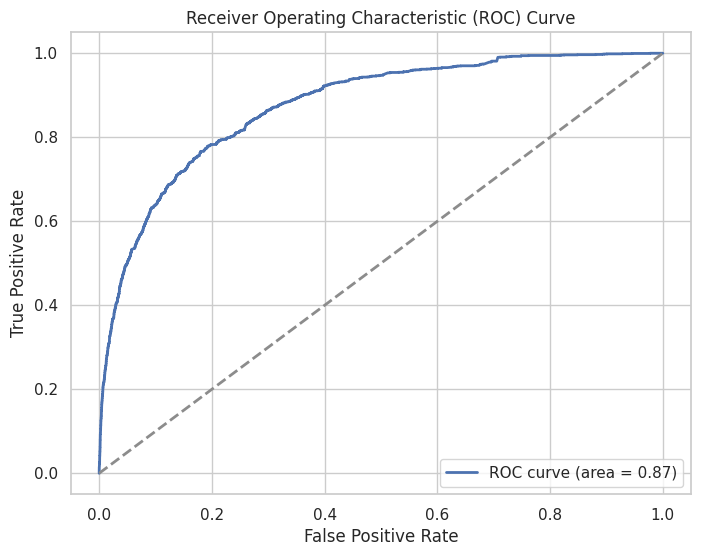

In [143]:
from scipy.special import softmax

#ROC y AUC
probabilities = softmax(preds.predictions, axis=1)[:, 1] #Usamos softmax para calcular las "probabilidades" del modelo
roc_auc = roc_auc_score(df_test_pre["label"], probabilities)
fpr, tpr, _ = roc_curve(df_test_pre["label"], probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc), color=sns.color_palette("deep")[0])
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color=sns.color_palette("deep")[7])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##Matriz de Confusión

Confirmamos que el problema del modelo es con falsos positivos, por lo que el modelo tiende a calificar como tóxicos muchos mensajes que en realidad no son tóxicos.

Si implementáramos nuestro modelo en producción, sería necesario tener esto en cuenta. En nuestro caso de detección de toxicidad es mucho mejor tener un falso positivo que un falso negativo (ya que es mucho peor no detectar un mensaje que realmente sí es tóxico).

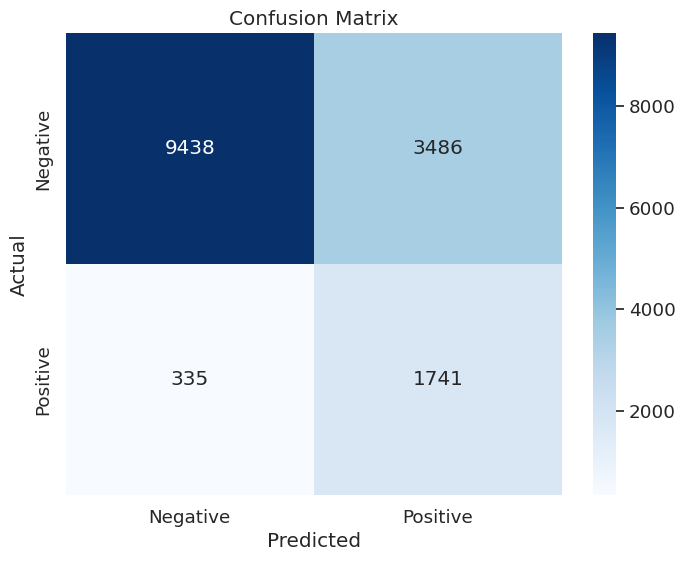

In [133]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Matriz de confusión
conf_mat = confusion_matrix(df_test_pre["label"], pred_labels)

#Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##WordCloud

Analizando el wordcloud en los casos donde el modelo falla, podemos ver que en el caso de los falsos positivos, hay un lenguaje muy parecido al que encontrabamos en el wordcloud de textos tóxicos del set de entrenamiento ("Sánchez", "PP", "gobierno", "PSOE"...)
Es muy posible que esto sea parte de la causa de por qué el modelo falla en esos casos.

Podemos ver que la palabra mayoritaria en ambos textos es "tweeter". Sin embargo, esto se debe, principalmente a que es la palabra más repetida en el dataset (ya que hemos introducido las ids dentro del modelo), por lo que no nos da mucha información.

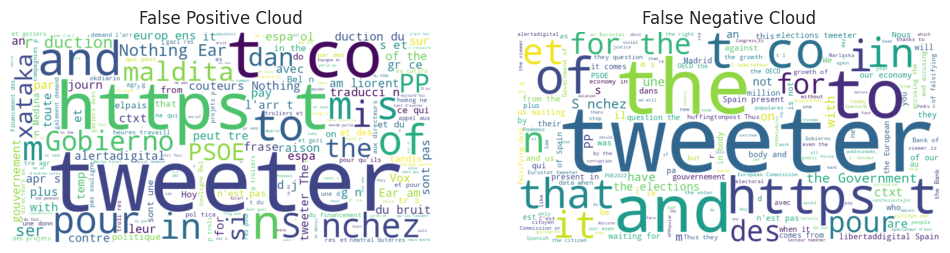

In [172]:
#Índices de falsos positivos
false_positive_indices = np.where((pred_labels == 1) & (df_test_pre["label"] == 0))[0]
false_negative_indices = np.where((pred_labels == 0) & (df_test_pre["label"] == 1))[0]

#Índices de falsos ngativos
false_positive_text = ' '.join(df_test_pre["text"].iloc[false_positive_indices])
false_negative_text = ' '.join(df_test_pre["text"].iloc[false_negative_indices])

#Wordclouds
false_positive_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words_spanish).generate(false_positive_text)
false_negative_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words_spanish).generate(false_negative_text)

#Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(false_positive_wordcloud, interpolation='bilinear')
plt.title('False Positive Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(false_negative_wordcloud, interpolation='bilinear')
plt.title('False Negative Cloud')
plt.axis('off')

plt.show()


##Muestreo

Con un sencillo muestreo de los casos de error del modelo, podemos ver que
- Los falsos positivos tienden a ser mensajes que no son tóxicos pero tienen a veces un tono controversial o crítico dentro de contextos polarizados (como la política).
- Los falsos negativos son mayoritariamente mensajes con lenguaje sutilmente tóxico o irónico.
- En general la mayoría de textos muestreados son políticos (lo cual tiene sentido ya que en estos textos parece ser donde hay más toxicidad en general)

In [177]:
false_positive_indices = df_test_pre[(df_test_pre['label'] == 0) & (pred_labels == 1)].index
false_negative_indices = df_test_pre[(df_test_pre['label'] == 1) & (pred_labels == 0)].index

print("False Positives:")
for index in false_positive_indices[:10]:
    print(f"- {df_test_pre['text'][index]}")

print("\nFalse Negatives:")
for index in false_negative_indices[:10]:
    print(f"- {df_test_pre['text'][index]}")

False Positives:
- [newtral] El ensayo con los espa?oles en el extranjero ser?a la ruta del voto por internet
- [alertadigital] ?Por qu? si se grab? en Gij?n, aparece a?os despu?s en otro lugar?
- [alertadigital] ?No pueden vendernos esta hip?tesis?
- [tweeter] La energ?a solar y la e?lica son cada vez m?s baratas y vapulean en costes al carb?n, el gas y la nuclear. 
- [tweeter] La pol?tica debe recuperar su protagonismo. Es el momento de enfatizar los consensos y aceptar sin miedo los disensos. Mesa de di?logo, reforma penal y libertad para los presos. 
- [tweeter] Dar cobertura medi?tica a un grupo inicialmente residual llamado vox nos ha salido estupendo. ?Q puede salir mal si le damos el micr?fono a una nazi? 

A estas alturas del partido ya tendr?amos q haber aprendido. Es exasperante
- [tweeter] Hoy va a ser un d?a hist?rico. De camino al Consejo de Ministras y Ministros que aprobar? la Ley Trans y de igualdad LGTBI. #EsLey:bandera_transg?nero::bandera_del_arco?ris::pu?o_en_alto_

#Posibles Mejoras

Por falta de tiempo o recursos, hay diferentes aproximaciones que no se han podido tratar pero que podrían haber ayudado a mejorar el modelo
- Hacer aumento de datos (_back translation_, cambio de sinónimos o el uso de algún modelo de lenguaje adaptado). Esto podría ayudar a mejorar el rendimiento del modelo y hacerlo más robusto, especialmente si se aumentan los datos de la clase minoritaria.
- Entrenar con más modelos de lenguaje y evaluar cual es el rendimiento de cada uno.

#Pregunta
Si tuvieses acceso a un LLMs (ChatGPT, LLaMa, etc, ¿Lo usarías? En caso afirmativo
desarrolla la respuesta (puedes dejar la respuesta a esta pregunta en una celda del
notebook)

Depende de cual sea el objetivo del proyecto. Aunque es verdad que el uso de un LLM casi seguro mejoraría los resultados del modelo, es posible que el coste de utilizar un LLM sea mayor que el beneficio que logremos en los resultados.

Sería necesario analizar
- El coste del LLM frente a nuestro modelo de bert (especialmente si el LLM es utilizado durante la inferencia en un modelo cuyo número de usuarios puede crecer).
- Los recursos de los que dispone nuestra empresa.
- El tiempo del que disponemos (a nivel de entrenamiento y de inferencia).
- La importancia de los resultados (hay tareas en las que no es tan preocupante fallar).
- La diferencia de resultados (es posible que en nuestro problema concreto no mejore tanto el resultado).
- La escalabilidad de nuestro modelo, especialmente si usamos un servicio como la API de chatgpt que cobra por número de tokens.

En base a lo visto, en el modelo lo más probable es que el coste del LLM sea mucho mayor a los beneficios que logremos. Posiblemente sería mejor el uso del LLM para generar nuevos datos de entrenamiento o aumentar los disponibles mediante el uso de un buen _prompt_ que utilice los datos que ya tenemos —ya sea para etiquetar texto del que dispongamos o para generarlo—.

Ahora bien, si la tarea de nuestro modelo requiere una gran precisión y disponemos de los recursos necesarios, es posible que merezca la pena implementar un LLM como base de nuestro modelo, ya sea utilizando _prompt engineering_, una técnica adaptativa como LoRA o un _fine-tuning_ del modelo (en orden creciente de coste y exactitud).